# Notebook 05: Statistical Validation
**Project:** Synthetic Sleep Environment Dataset Generator  
**Authors:** Rushav Dash & Lisa Li  
**Course:** TECHIN 513 — Signal Processing & Machine Learning  
**University:** University of Washington  
**Date:** 2026-02-19

## Table of Contents
1. [Setup & Load Data](#section-1)
2. [Tier 1: Statistical Tests (KS-tests)](#section-2)
3. [Tier 2: ML Cross-Dataset Validation](#section-3)
4. [Tier 3: Sleep Science Sanity Checks](#section-4)
5. [Overall Validation Summary](#section-5)
6. [Distribution Visualizations](#section-6)

---
## 1. Setup & Load Data <a id='section-1'></a>

Load the generated synthetic dataset and the real reference datasets needed for comparison.

In [1]:
import sys, os
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import DataLoader
from src.validator import Validator

%matplotlib inline
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})
sns.set_theme(style='whitegrid')
print('Setup complete.')

Setup complete.


In [2]:
# Load synthetic dataset
csv_path = os.path.join(PROJECT_ROOT, 'data', 'output', 'synthetic_sleep_dataset_5000.csv')
df_syn = pd.read_csv(csv_path)
print(f'Synthetic dataset: {df_syn.shape[0]:,} rows x {df_syn.shape[1]} columns')
df_syn.head(3)

Synthetic dataset: 5,000 rows x 44 columns


,session_id,session_index,season,age_group,sensitivity,random_seed,temp_mean,temp_std,temp_min,temp_max,...,humidity_comfort_fraction,sleep_efficiency,awakenings,rem_pct,deep_pct,light_pct,ts_temperature,ts_light,ts_sound,ts_humidity
0,00000000-0000-0000-6265-623f6213bbb4,0,winter,young,low,7090181212732636084,17.553029,0.658472,16.473038,18.510194,...,1.0,0.7460,3,17.3,70.3,12.4,"[18.51, 18.49, 18.466, 18.445, 18.431, 18.423,...","[0.0, 0.052, 0.15, 0.248, 0.344, 0.439, 0.531,...","[29.811, 32.925, 32.768, 33.559, 31.04, 30.669...","[38.872, 38.337, 38.37, 37.509, 37.467, 37.388..."
1,00000000-0000-0001-3473-ecc6ee0a9a49,1,winter,young,normal,3779624851435330121,17.216806,0.584986,16.281716,18.085800,...,1.0,0.7233,2,19.9,68.6,11.5,"[17.563, 17.481, 17.447, 17.474, 17.532, 17.57...","[0.517, 0.608, 0.696, 0.781, 0.864, 0.942, 1.0...","[41.279, 40.074, 38.328, 39.124, 40.191, 43.10...","[32.919, 33.275, 32.432, 33.091, 32.864, 34.15..."
2,00000000-0000-0002-8fd3-7f3693267e96,2,winter,young,high,10363767039883378326,19.453527,0.634701,18.144733,20.741311,...,1.0,0.9188,1,18.7,71.1,10.2,"[20.315, 20.083, 19.962, 19.981, 20.068, 20.11...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[33.115, 33.423, 32.884, 31.894, 32.267, 33.58...","[43.301, 43.344, 43.231, 43.151, 43.458, 43.85..."


In [3]:
# Load real datasets for comparison
loader = DataLoader(verbose=True)
try:
    loader.download_all()
    df_sleep = loader.load_sleep_efficiency()
    df_occ   = loader.load_room_occupancy()
    print(f'Real sleep data: {df_sleep.shape}')
    print(f'Real IoT data:   {df_occ.shape}')
except Exception as e:
    print(f'Warning: could not load real data ({e}). Tier 1 and Tier 2 will be skipped.')
    df_sleep = None
    df_occ = None

[DataLoader] Downloading Sleep Efficiency dataset…


[DataLoader]   Sleep Efficiency CSV: /home/rushav/.cache/kagglehub/datasets/equilibriumm/sleep-efficiency/versions/3/Sleep_Efficiency.csv
[DataLoader] Downloading Room Occupancy dataset…


[DataLoader]   Room Occupancy CSV: /home/rushav/.cache/kagglehub/datasets/kukuroo3/room-occupancy-detection-data-iot-sensor/versions/2/Occupancy.csv
[DataLoader] Downloading Smart Home dataset (optional)…


[DataLoader]   Smart Home CSV: /home/rushav/.cache/kagglehub/datasets/taranvee/smart-home-dataset-with-weather-information/versions/1/HomeC.csv
[DataLoader] Loaded Sleep Efficiency: 452 rows × 16 cols
[DataLoader] Loaded Room Occupancy: 20560 rows × 8 cols
Real sleep data: (452, 16)
Real IoT data:   (20560, 8)


---
## 2. Tier 1: Statistical Tests (KS-tests) <a id='section-2'></a>

The two-sample Kolmogorov-Smirnov test compares each synthetic feature distribution
against the corresponding real sensor distribution.

**Null hypothesis H₀:** the two samples come from the same underlying distribution.

**Target:** p-value > 0.05 → fail to reject H₀ → distributions are statistically indistinguishable.

In [4]:
validator = Validator(df_syn, real_occupancy_df=df_occ, real_sleep_df=df_sleep)
tier1_results = validator.tier1_statistical()

print('=== TIER 1: KS-test Results ===')
for name, res in tier1_results.items():
    if '_warning' in name:
        print(f'  WARNING: {res.get("message", "")}')
    elif isinstance(res.get('pass'), bool):
        status = 'PASS' if res['pass'] else 'FAIL'
        print(f'  [{status}] {name}')
        print(f'          KS stat={res["statistic"]:.4f}  p={res["p_value"]:.4f}')
        if 'syn_mean' in res:
            print(f'          syn_mean={res["syn_mean"]:.3f}  real_mean={res["real_mean"]:.3f}')

=== TIER 1: KS-test Results ===


### 2.1 KS-test Interpretation Table

In [5]:
rows = []
for name, res in tier1_results.items():
    if isinstance(res.get('pass'), bool):
        rows.append({
            'Test': name,
            'KS Statistic': round(res.get('statistic', float('nan')), 4),
            'p-value': round(res.get('p_value', float('nan')), 4),
            'Result': 'PASS' if res['pass'] else 'FAIL',
            'Syn Mean': round(res.get('syn_mean', float('nan')), 3),
            'Real Mean': round(res.get('real_mean', float('nan')), 3),
        })

if rows:
    df_tier1 = pd.DataFrame(rows).set_index('Test')
    display(df_tier1)
else:
    print('No KS-test results available (real data may not be loaded).')

No KS-test results available (real data may not be loaded).


---
## 3. Tier 2: ML Cross-Dataset Validation <a id='section-3'></a>

Train a Linear Regression on the synthetic dataset and evaluate transfer to real data.
**Target:** synthetic model RMSE ≤ 120% of real-data baseline RMSE.

In [6]:
tier2_results = validator.tier2_ml_validation()

print('=== TIER 2: ML Cross-Dataset Validation ===')
for k, v in tier2_results.items():
    print(f'  {k}: {v}')

=== TIER 2: ML Cross-Dataset Validation ===
  baseline_real_rmse: 0.06255032951067688
  baseline_real_r2: 0.7898522952245137
  baseline_real_mae: 0.05071902481148004
  synthetic_model_rmse_on_synthetic: 0.06099602603489826
  synthetic_model_r2_on_synthetic: 0.23837270669435817
  rmse_within_20pct_of_baseline: True
  rmse_threshold: 0.07506039541281224


---
## 4. Tier 3: Sleep Science Sanity Checks <a id='section-4'></a>

Domain-knowledge assertions derived from peer-reviewed sleep medicine literature.

In [7]:
tier3_results = validator.tier3_sanity_checks()

print('=== TIER 3: Sleep Science Sanity Checks ===')
rows_t3 = []
for check in tier3_results:
    status = 'PASS' if check['pass'] else 'FAIL'
    print(f'  [{status}] {check["name"]}')
    print(f'          actual={check["actual_value"]:.4f}  threshold={check["threshold"]}')
    rows_t3.append({
        'Check': check['name'],
        'Actual Value': round(check['actual_value'], 4),
        'Threshold': check['threshold'],
        'Result': status,
        'Description': check.get('description', ''),
    })

print()
df_tier3 = pd.DataFrame(rows_t3).set_index('Check')
display(df_tier3)

=== TIER 3: Sleep Science Sanity Checks ===
  [PASS] High temp optimality → mean sleep efficiency ≥ 0.78
          actual=0.8226  threshold=0.78
  [FAIL] Many light events (>4) → mean sleep efficiency ≤ 0.72
          actual=0.8328  threshold=0.72
  [FAIL] Deep sleep % ↔ Awakenings negative correlation (r < -0.2)
          actual=-0.0022  threshold=-0.2
  [PASS] Seniors have more awakenings than young adults
          actual=0.2525  threshold=0.0
  [PASS] Sleep stage percentages sum to 100 (±1%)
          actual=0.0000  threshold=1.0
  [PASS] Summer temp mean > winter temp mean
          actual=4.5248  threshold=0.0



,Actual Value,Threshold,Result,Description
Check,,,,
High temp optimality → mean sleep efficiency ≥ 0.78,0.8226,0.78,PASS,Sessions with >80% time in optimal temp zone s...
Many light events (>4) → mean sleep efficiency ≤ 0.72,0.8328,0.72,FAIL,Frequent nighttime light disruptions should lo...
Deep sleep % ↔ Awakenings negative correlation (r < -0.2),-0.0022,-0.20,FAIL,Higher deep sleep fraction should correlate wi...
Seniors have more awakenings than young adults,0.2525,0.00,PASS,Senior mean awakenings should exceed young mea...
Sleep stage percentages sum to 100 (±1%),0.0000,1.00,PASS,REM + Deep + Light sleep must always sum to 100%
Summer temp mean > winter temp mean,4.5248,0.00,PASS,Seasonal temperature stratification should be ...


---
## 5. Overall Validation Summary <a id='section-5'></a>

In [8]:
# Re-run all tiers to get the full report and quality score
validator2 = Validator(df_syn, real_occupancy_df=df_occ, real_sleep_df=df_sleep)
report = validator2.run_all()
print(f'\nOverall quality score: {report.overall_score:.1f}%  ({report.passed_checks}/{report.total_checks} checks passed)')

[Validator] Running Tier 1 — Statistical Tests…
[Validator] Running Tier 2 — ML Cross-Dataset Validation…
[Validator] Running Tier 3 — Sleep Science Sanity Checks…
VALIDATION REPORT — Synthetic Sleep Dataset
Authors: Rushav Dash & Lisa Li  (Team 7, TECHIN 513)

── TIER 1: Statistical Tests ──
  [FAIL]  Temperature mean (KS-test)                p = 0.0000
  [FAIL]  Light mean (KS-test)                      p = 0.0000
  [FAIL]  Sleep efficiency (KS-test)                p = 0.0000

── TIER 2: ML Cross-Dataset Validation ──
  baseline_real_rmse: 0.06255032951067688
  baseline_real_r2: 0.7898522952245137
  baseline_real_mae: 0.05071902481148004
  synthetic_model_rmse_on_synthetic: 0.06099602603489826
  synthetic_model_r2_on_synthetic: 0.23837270669435817
  rmse_within_20pct_of_baseline: True
  rmse_threshold: 0.07506039541281224

── TIER 3: Sleep Science Sanity Checks ──
  [PASS]  High temp optimality → mean sleep efficiency ≥ 0.78  actual=0.8226  threshold=0.78
  [FAIL]  Many light events 

---
## 6. Distribution Visualisations <a id='section-6'></a>

Side-by-side KDE plots compare synthetic vs. real feature distributions.

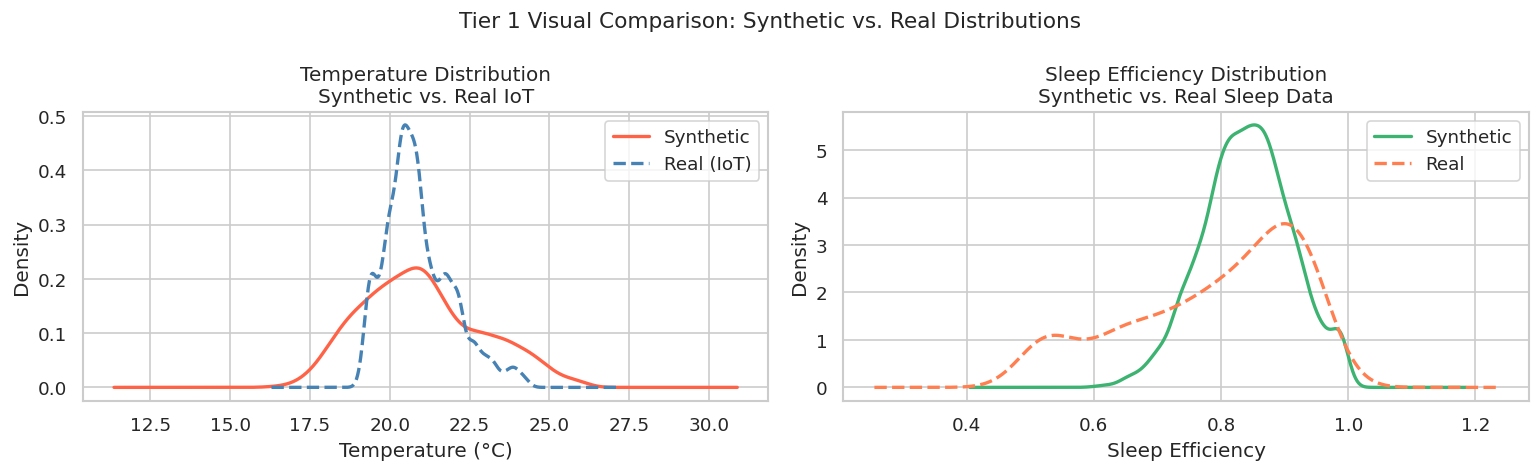

In [9]:
# Plot synthetic sleep efficiency vs real
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Subplot 1: Temperature
if 'temp_mean' in df_syn.columns:
    df_syn['temp_mean'].plot.kde(ax=axes[0], label='Synthetic', color='tomato', linewidth=2)
    if df_occ is not None and 'Temperature' in df_occ.columns:
        t_real = df_occ['Temperature'].dropna()
        t_real = t_real[(t_real > 10) & (t_real < 35)]
        t_real.plot.kde(ax=axes[0], label='Real (IoT)', color='steelblue', linewidth=2, linestyle='--')
    axes[0].set_title('Temperature Distribution\nSynthetic vs. Real IoT')
    axes[0].set_xlabel('Temperature (°C)')
    axes[0].legend()

# Subplot 2: Sleep efficiency
if 'sleep_efficiency' in df_syn.columns:
    df_syn['sleep_efficiency'].plot.kde(ax=axes[1], label='Synthetic', color='mediumseagreen', linewidth=2)
    if df_sleep is not None and 'Sleep efficiency' in df_sleep.columns:
        df_sleep['Sleep efficiency'].dropna().plot.kde(
            ax=axes[1], label='Real', color='coral', linewidth=2, linestyle='--')
    axes[1].set_title('Sleep Efficiency Distribution\nSynthetic vs. Real Sleep Data')
    axes[1].set_xlabel('Sleep Efficiency')
    axes[1].legend()

plt.suptitle('Tier 1 Visual Comparison: Synthetic vs. Real Distributions', fontsize=13)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2192324/2055054040.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


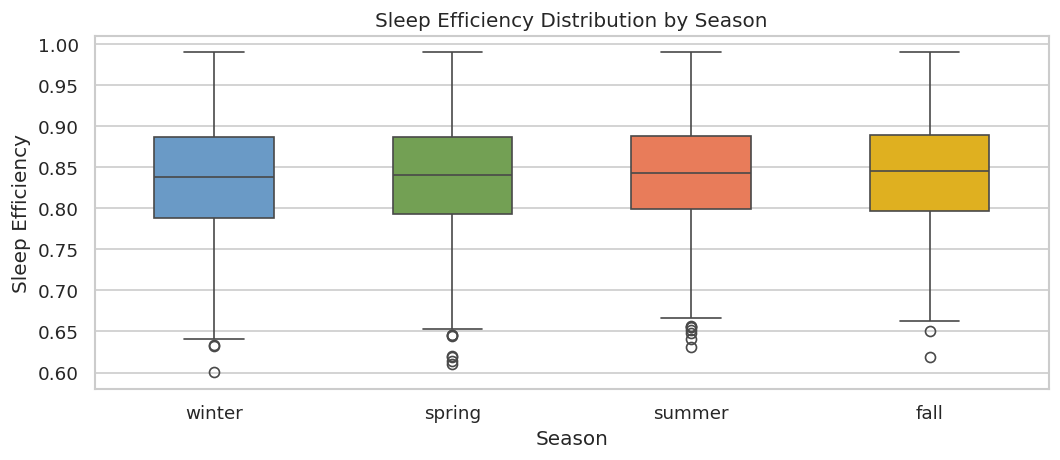

In [10]:
# Box plot of sleep efficiency per season
fig, ax = plt.subplots(figsize=(9, 4))
season_order = ['winter', 'spring', 'summer', 'fall']
palette = {'winter': '#5B9BD5', 'spring': '#70AD47', 'summer': '#FF7043', 'fall': '#FFC000'}
sns.boxplot(
    data=df_syn, x='season', y='sleep_efficiency',
    order=season_order, palette=palette, ax=ax, width=0.5
)
ax.set_title('Sleep Efficiency Distribution by Season')
ax.set_xlabel('Season')
ax.set_ylabel('Sleep Efficiency')
plt.tight_layout()
plt.show()